## Model discovery for PDE

In this notebook we use the DeepMoD algorithm applied on the the PDE of an EWH. This version is just a test on the simulation datas. A final version will be developped when we have access to test bench again.

We start by importing the required DeepMoD functions:

In [13]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


Before we send the data into the Dataset format, create a plot to get an idea of the data:


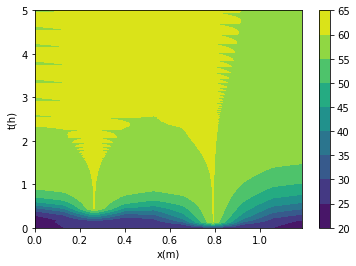

In [14]:
data = np.load('EWH_sim_NullFlow_CN_data.npy', allow_pickle=True).item()
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t']/3600, np.real(data['u']))
ax.set_xlabel('x(m)')
ax.set_ylabel('t(h)')
fig.colorbar(mappable=im)

plt.show()

We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [15]:
def load_data():
    array = np.load('EWH_sim_NullFlow_CN_data.npy', allow_pickle=True).item()
    coords = torch.from_numpy(np.stack((array["t"],array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

First of all, We'll create a subclasse of Dataset(a custum version of the classe) which have Q and V as extra arguments

In [17]:
class Dataset_EWH(Dataset):
    def __init__(
        self,
        load_function,
        Q, 
        V,
        apply_normalize=None,
        apply_noise=None,
        apply_shuffle=None,
        shuffle=True,
        subsampler: Subsampler = None,
        load_kwargs: dict = {},
        preprocess_kwargs: dict = {
            "random_state": 42,
            "noise_level": 0.0,
            "normalize_coords": False,
            "normalize_data": False,
        },
        subsampler_kwargs: dict = {},
        device: str = None,
    ):
        '''
        Same class as Dataset BUT, we'll introduce Q and V matrice for the prupose of our model
        Args:
            load_function (func):Must return torch tensors in the format coordinates, data
            Q: Matrix containing the  value of Q(x,t) in a tensor form(same shape as u)
            V: Matrix containing the  value of V(x,t)(even if V is the same along x) in a tensor form(same shape as u)
            shuffle (bool, optional): Shuffle the data. Defaults to True.
            apply_normalize (func)
            subsampler (Subsampler, optional): Add some subsampling function. Defaults to None.
            load_kwargs (dict, optional): kwargs to pass to the load_function. Defaults to {}.
            preprocess_kwargs (dict, optional): (optional) arguments to pass to the preprocess method. Defaults to { "random_state": 42, "noise_level": 0.0, "normalize_coords": False, "normalize_data": False, }.
            subsampler_kwargs (dict, optional): (optional) arguments to pass to the subsampler method. Defaults to {}.
            device (str, optional): which device to send the data to. Defaults to None.
        '''
        super()._init_(
        load_function,
        apply_normalize=None,
        apply_noise=None,
        apply_shuffle=None,
        shuffle=True,
        subsampler: Subsampler = None,
        load_kwargs: dict = {},
        preprocess_kwargs: dict = {
            "random_state": 42,
            "noise_level": 0.0,
            "normalize_coords": False,
            "normalize_data": False,
        },
        subsampler_kwargs: dict = {},
        device: str = None,
        )

        self.Q = Q
        self.V = V
        

SyntaxError: invalid syntax (393145568.py, line 41)

We can now pass the function that loads the data to the DeePyMoD Dataset module, which loads the data, preprocesses it, subsamples it and then sends it to the right device.

In [ ]:
Q = torch.from_numpy(np.real(data["Q"])).unsqueeze(-1).float()
V = torch.from_numpy(np.real(data["V"])).unsqueeze(-1).float()

dataset = Dataset_EWH(
    load_data,
    Q,V,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 5000},
    device=device,
)

Dataset is using device:  cpu


Now we need to split our data into a train and test dataloaders for PyTorch

In [ ]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

# Setup a custom library

In this cell we'll create a custom build library.The library function, $\theta$, in this case contains $[1,u,u_x, u_xx, V*u_x, Q]$ . But how to insert Q and V in our dataset. We could think about a subclass of dataset were we'll add some extra arguments Huuuuuuuuuuuuuuuum.🤔🤔🤔